# Big Data in Finance: Assignment 1

This jupyter notebook accompanies the PDF submitted by our team and does not include explanations to many questions asked in the prompts.

<b>Submission by:</b><br>
Alice Castrucci - 01588236<br>
Danesh Gilani - 01570788<br>
Johannes Breitschwerdt - 01612332<br>
Jose Alvarez - 01563720<br>

# Part 1

First, we load all the libaries required for this notebook, and load the data

In [113]:
#Import all libraries for this notebook
import pandas as pd
import numpy as np

from sklearn import model_selection

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import scikitplot as skplt
from sklearn.metrics import roc_curve,auc
import matplotlib.pylab as plt
from scipy import interp

from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings('ignore')

In [201]:
#Load data for part 1
df = pd.read_csv('Loan_data_part_I.csv')
df.head()

,id,loan_status,loan_amnt,term,int_rate,grade,sub_grade,installment,pymnt_plan,annual_inc,...,pub_rec_bankruptcies,revol_bal,revol_util,tax_liens,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit
0,114133086,Current,18000.0,36,11.99,1,9,597.78,0,40800.0,...,0.0,11022.0,62.6,0.0,73967.0,92443.0,67.0,73967.0,62945.0,12700.0
1,113327093,Current,36000.0,36,16.02,2,14,1266.01,0,98000.0,...,0.0,24455.0,63.5,0.0,37296.0,55621.0,28.0,37296.0,12841.0,17200.0
2,119396821,Current,1200.0,36,16.02,2,14,42.21,0,48000.0,...,0.0,8371.0,85.4,0.0,24227.0,35259.0,24.0,24227.0,15856.0,7800.0
3,113509028,Current,24000.0,60,10.42,1,7,514.91,0,63000.0,...,0.0,6162.0,38.3,0.0,124925.0,196850.0,15.0,6612.0,0.0,13500.0
4,114749248,Current,12000.0,36,7.07,0,1,370.91,0,120000.0,...,0.0,15025.0,26.7,0.0,15720.0,57242.0,12.0,15720.0,0.0,47800.0


Next, we convert the $loan\_status$ column to be binary, with 0 for 'Current' and 1 for 'Fail'

In [202]:
#Make loan_status binary: current = 0, fail = 1
df['loan_status'] = df['loan_status'].replace(['Current', 'Fail'], [0, 1])
df = df.drop(['id'], axis = 1) #drop id from dataframe
df.head()

,loan_status,loan_amnt,term,int_rate,grade,sub_grade,installment,pymnt_plan,annual_inc,emp_length,...,pub_rec_bankruptcies,revol_bal,revol_util,tax_liens,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit
0,0,18000.0,36,11.99,1,9,597.78,0,40800.0,0,...,0.0,11022.0,62.6,0.0,73967.0,92443.0,67.0,73967.0,62945.0,12700.0
1,0,36000.0,36,16.02,2,14,1266.01,0,98000.0,10,...,0.0,24455.0,63.5,0.0,37296.0,55621.0,28.0,37296.0,12841.0,17200.0
2,0,1200.0,36,16.02,2,14,42.21,0,48000.0,1,...,0.0,8371.0,85.4,0.0,24227.0,35259.0,24.0,24227.0,15856.0,7800.0
3,0,24000.0,60,10.42,1,7,514.91,0,63000.0,10,...,0.0,6162.0,38.3,0.0,124925.0,196850.0,15.0,6612.0,0.0,13500.0
4,0,12000.0,36,7.07,0,1,370.91,0,120000.0,4,...,0.0,15025.0,26.7,0.0,15720.0,57242.0,12.0,15720.0,0.0,47800.0


We can now easily gain some insight into the data by understanding how many negatives ('Current' or no default) and positives ('Fail' or default) observations are present.

In [116]:
#Return the number of default in the data
nrows = len(df)
df_fail = df['loan_status'].sum()
print('There are', nrows, 'rows in this dataset, with', df_fail, 'or', round(df_fail/nrows*100,2), '% \'loan_status = fail\'')

There are 61072 rows in this dataset, with 9666 or 15.83 % 'loan_status = fail'


Next, we check for missing values in each cell of the data. We find that all there are no missing values in any cells.

In [117]:
#Check each column for "null" values
print('There are', sum(df.isnull().sum()), 'instances of missing data in all', len(df.columns), 'columns')

There are 0 instances of missing data in all 47 columns


Subsequently, since the data contains three attributes with categorical data ('home_ownership', 'purpose', 'verification_status'), we replace these columns with dummy variable columns with binary data {0,1}. 

In [118]:
#Convert categorical columns to binary
df_dum = pd.get_dummies(df, columns = ['home_ownership', 'purpose', 'verification_status'], drop_first = True)

In [119]:
df_dum.head()

,loan_status,loan_amnt,term,int_rate,grade,sub_grade,installment,pymnt_plan,annual_inc,emp_length,...,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,purpose_11,verification_status_1,verification_status_2
0,0,18000.0,36,11.99,1,9,597.78,0,40800.0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,36000.0,36,16.02,2,14,1266.01,0,98000.0,10,...,0,0,0,0,0,0,0,0,0,1
2,0,1200.0,36,16.02,2,14,42.21,0,48000.0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,24000.0,60,10.42,1,7,514.91,0,63000.0,10,...,0,1,0,0,0,0,0,0,0,0
4,0,12000.0,36,7.07,0,1,370.91,0,120000.0,4,...,0,0,0,0,0,0,0,0,0,0


We now shuffle the data and then finally split the data into predictors and the outcomes.

In [120]:
#Shuffle data frame
df_s = shuffle(df_dum) 

In [122]:
#Separate dependent (y) and independent (X) variables
X = np.array(df_s[df_s.columns[1:]])
y = np.array(df_s['loan_status'])

### 1. Apply three machine-learning techniques to the Full Model

Before we run any model, we scale our data using z-score normalization - this data will only be used for certain models since some do not require scaled data - and we initialize the 10-fold cross validation function.

In [123]:
#Scale all independent variables using Z-Score normalisation
z_scaler = StandardScaler().fit(X)
X_sc = z_scaler.transform(X)

In [124]:
#Initialize kfold cross validation (k = 10)
k = 10
kfold = model_selection.KFold(n_splits = k, shuffle = False)

#### Linear Discriminant Analysis

We initialize and run the LDA classifier using kfold cross validation on the scaled data. We report the accuracy and then report a confusion matrix for this model.

In [125]:
#Run LDA classifier using kfold cross validation on the z score scaled data
LDA = LinearDiscriminantAnalysis()
score_LDA = model_selection.cross_val_score(LDA, X_sc, y, cv = kfold)
mean_score_LDA = score_LDA.mean()
print('The LDA full model accuracy is %s%%\n' %round(mean_score_LDA*100, 2))

The LDA full model accuracy is 84.03%



In [126]:
#Create confusion matrix using kfold cross validation
pred_LDA = cross_val_predict(LDA, X_sc, y, cv = kfold)
conf = confusion_matrix(y, pred_LDA)
conf_LDA = conf.transpose()
conf_LDA = normalize(conf_LDA, axis=0, norm='l1')
conf_LDA = pd.DataFrame(conf_LDA, index = ['Pred \'Current\'', 'Pred \'Fail\''],
                            columns = ['Act \'Current\'', 'Act \'Fail\''])

print(conf_LDA)

                Act 'Current'  Act 'Fail'
Pred 'Current'       0.978718    0.895924
Pred 'Fail'          0.021282    0.104076


#### Classification Tree Model

In order to choose the depth parameter for the tree model, we first find the optimal tree depth by comparing the accuracy for trees with depths from 1 to 10. As seen below, we find that the optimal depth below.

In [228]:
#Find optimal tree depth
tree_cv_scores = []

for i in range(1, 10): 
    tree = DecisionTreeClassifier(max_depth = i)
    scores = model_selection.cross_val_score(tree, X, y, cv = kfold) 
    tree_cv_scores.append(scores.mean())
    
opt_depth = tree_cv_scores.index(max(tree_cv_scores)) + 1
print('Optimal tree depth:', opt_depth)

Optimal tree depth: 4


We then run the tree using 10fold cross validation on the unscaled data. We report the accuracy of this model, and the confusion matrix for it as well.

In [128]:
#Build tree using kfold cross validation and optimal tree depth = 3 on unscaled data
tree_3 = DecisionTreeClassifier(max_depth = opt_depth)
tree_scores = model_selection.cross_val_score(tree_3, X, y, cv = kfold)
mean_score_tree = tree_scores.mean()
print('The Tree full model accuracy is %s%%\n' %round(mean_score_tree*100, 2))

The Tree full model accuracy is 84.3%



In [129]:
#Create confusion matrix using kfold cross validation
pred_tree = cross_val_predict(tree_3, X, y, cv=kfold)
conf = confusion_matrix(y, pred_tree)
conf_tree = conf.transpose()
conf_tree = normalize(conf_tree, axis=0, norm='l1')
conf_tree = pd.DataFrame(conf_tree, index = ['Pred \'Current\'', 'Pred \'Fail\''],
                            columns = ['Act \'Current\'', 'Act \'Fail\''])

print(conf_tree)

                Act 'Current'  Act 'Fail'
Pred 'Current'       0.996615    0.974033
Pred 'Fail'          0.003385    0.025967


#### 5-Neareast Neighbours Classifier

We apply a nearest-neighbour classifier with neighbours = 5 using 10-fold cross validation on the scaled data. Next, we run the 5NN model, report the accuracy, and finally report the confusion matrix for this model.

In [130]:
#Initialize and Score KNN classifier in-sample using kfold cross validation on scaled data
neigh = 5
knn = KNeighborsClassifier(n_neighbors = neigh)
knn_scores = model_selection.cross_val_score(knn, X_sc, y, cv = kfold)
mean_scores_knn = knn_scores.mean()
print('The KNN full model accuracy is %s%%\n' %round(mean_scores_knn*100, 2))

The KNN full model accuracy is 82.92%



In [131]:
#Create confusion matrix using kfold cross validation
pred_knn = cross_val_predict(knn, X_sc, y, cv = kfold)
conf = confusion_matrix(y, pred_knn)
conf_knn = conf.transpose()
conf_knn = normalize(conf_knn, axis=0, norm='l1')
conf_knn = pd.DataFrame(conf_knn, index = ['Pred \'Current\'', 'Pred \'Fail\''],
                            columns = ['Act \'Current\'', 'Act \'Fail\''])

print(conf_knn)

                Act 'Current'  Act 'Fail'
Pred 'Current'       0.968078    0.909477
Pred 'Fail'          0.031922    0.090523


## 2. Run 5-NN, Tree, LDA on Undersampled Dataset

In order to run the 10-fold cross validation correctly on undersampled data, we first define the `classifier` function below. This function allows us to correctly train using the undersampled data, but validate using non-undersampled data. This means that each fold, within the 10-fold cross validation, will run an Undersample function to change only the training set data in that fold.

In [132]:
#Define function to allow classifier to properly oversample only training data in kfold cross validation 
def classifier(classifier_type, X, y):
    kfold = KFold(n_splits = k, random_state = 42)
    kfold.get_n_splits(X)

    score_list = []
    best_score = 0

    conf_matrix = np.zeros((2, 2))

    for train_index, valid_index in kfold.split(X):
        #Split training / validation set at Kth fold
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        #Undersample training data
        rus = RandomUnderSampler(random_state = 42)
        X_res, y_res = rus.fit_resample(X_train, y_train)
        
        #Scale undersampled training set and validation set, using scale fit from training data
        scaler = StandardScaler().fit(X_res)
        X_train_scaled = scaler.transform(X_res)
        X_valid_scaled = scaler.transform(X_valid)
    
        #Create classifier object
        clf = classifier_type
        clf.fit(X_train_scaled, y_res)
        score = clf.score(X_valid_scaled, y_valid)
        score_list.append(score)
        
        #Set best score
        if score > best_score:
            best_train_index = train_index
            best_valid_index = valid_index
                               
        #Create confusion matrix for fold k
        conf = confusion_matrix(y_valid, clf.predict(X_valid_scaled))
    
        #Iteratively add confusion matrix to previous
        conf_matrix[0][0] += conf[0][0]
        conf_matrix[0][1] += conf[0][1]
        conf_matrix[1][0] += conf[1][0]
        conf_matrix[1][1] += conf[1][1]


    conf_clf = conf_matrix.transpose()
    conf_clf = normalize(conf_clf, axis = 0, norm = 'l1')
    conf_clf = pd.DataFrame(conf_clf, index = ['Pred \'Current\'', 'Pred \'Fail\''],
                                columns = ['Act \'Current\'', 'Act \'Fail\''])
    avg_accuracy = sum(score_list) / len(score_list)
    avg_accuracy
    
    return conf_clf, avg_accuracy

**Linear Discriminant Analysis with Undersampled Data**

We run the LDA model using the undersampling function above, report the accuracy and return the confusion matrix.

In [176]:
#Run LDA on undersampled data and return accuracy
conf_LDA_us, score_LDA_us = classifier(LinearDiscriminantAnalysis(), X, y)
print('The accuracy of the LDA model with undersampling is %s%%\n' %round((score_LDA_us*100),2))

The accuracy of the LDA model with undersampling is 66.13%



In [134]:
#Return confidence matrix for LDA on undersampled data
print(conf_LDA_us)

                Act 'Current'  Act 'Fail'
Pred 'Current'       0.666712    0.367577
Pred 'Fail'          0.333288    0.632423


**Tree Model with Undersampled Data**

We use the same function but with a Tree model, and we report the accuracy and return the confusion matrix.

In [175]:
#Run tree on undersampled data and return accuracy
conf_tree_us, score_tree_us = classifier(DecisionTreeClassifier(), X, y)
print('The accuracy of the tree model with undersampling is %s%%\n' %round((score_tree_us*100),2))

The accuracy of the tree model with undersampling is 56.65%



In [136]:
#Return confidence matrix for tree on undersampled data
print(conf_tree_us)

                Act 'Current'  Act 'Fail'
Pred 'Current'       0.565887    0.430581
Pred 'Fail'          0.434113    0.569419


**5-Nearest Neighbour with Undersampled Data**

Finally, we run a 5-NN model reporting the accuracy and return the confusion matrix.

In [177]:
#Run 5-NN on undersampled data and return accuracy
conf_knn_us, score_knn_us = classifier(KNeighborsClassifier(n_neighbors = neigh), X, y)
print('The accuracy of the 5-NN model with undersampling is %s%%\n' %round((score_knn_us*100),2))

The accuracy of the 5-NN model with undersampling is 61.8%



In [138]:
#Return confidence matrix for 5-NN on undersampled data
print(conf_knn_us)

                Act 'Current'  Act 'Fail'
Pred 'Current'       0.628681    0.438547
Pred 'Fail'          0.371319    0.561453


## 3. Feature Selection

### 3(a) Selecting features based on knowledge and intuition

Based on the detailed response provided in the submitted PDF, the following features were selected based on our knowledge and intuition

In [139]:
features = ['annual_inc', 'avg_cur_bal', 'delinq_2yrs', 'inq_last_6mths', 'installment', 
            'grade', 'tot_hi_cred_lim', 'dti', 'revol_bal', 'total_bal_ex_mort']

### 3(b) Creating reduced dataframe model
We select the 10 features of the original shuffled dataframe

In [140]:
#Create new reduced dependent (y) and independent (X) variables
red_columns = features
X_reduced = np.array(df_s[red_columns])
y_reduced = np.array(df_s['loan_status'])

**Logistic Regression on Reduced model**

We run a Logistic regression using the reduced dataset and return both the accuracy and the confusion matrix.

In [178]:
#Run Logit on reduced model and return accuracy
logit = LogisticRegression(solver = 'lbfgs')
conf_log_red, score_log_red = classifier(logit, X_reduced, y_reduced)
print('The accuracy of the logistic regression model is %s%%\n' %round((score_log_red*100),2))

The accuracy of the logistic regression model is 66.64%



In [142]:
#Return confidence matrix for Logit on reduced model
print(conf_log_red)

                Act 'Current'  Act 'Fail'
Pred 'Current'       0.677839    0.394579
Pred 'Fail'          0.322161    0.605421


**Tree Model on Reduced model**

Next we do the same for the Tree model - run the model using the reduced model and return both the accuracy and the confusion matrix.

In [180]:
#Run Tree on reduced model and return accuracy
conf_tree_red, score_tree_red = classifier(DecisionTreeClassifier(), X_reduced, y_reduced)
print('The accuracy of the reduced tree model is %s%%\n' %round((score_tree_red*100),2))

The accuracy of the reduced tree model is 56.19%



In [146]:
#Return confidence matrix for Tree on reduced model
print(conf_tree_red)

                Act 'Current'  Act 'Fail'
Pred 'Current'        0.56188    0.433892
Pred 'Fail'           0.43812    0.566108


**5-Nearest Neighbour Classifier on Reduced model**

Lastly, we run the reduced model using 5-NN method. We report the accuracy and the confusion matrix.

In [179]:
#Run 5-NN on reduced model and return accuracy
conf_knn_red, score_knn_red = classifier(KNeighborsClassifier(n_neighbors = neigh), X_reduced, y_reduced)
print('The accuracy of the 5-NN reduced model is %s%%\n' %round((score_knn_red*100),2))

The accuracy of the 5-NN reduced model is 59.47%



In [144]:
#Return confidence matrix for 5-NN on reduced model
print(conf_knn_red)

                Act 'Current'  Act 'Fail'
Pred 'Current'       0.593938    0.401304
Pred 'Fail'          0.406062    0.598696


## 4. ROC Curve

In order to draw the ROC curve for each fold within the k-fold cross validation, we define the `draw_ROC` function below. This functions iterates through each fold and draws a ROC curve. It displays each fold's ROC curve and a final mean ROC curve.

In [147]:
#Define function to draw ROC curve for each iteration through kfold cross validation, and mean ROC curve

# ROC FUNCTION BELOW IS BORROWS HEAVILY FROM FOLLOWING KERNEL:
# Title: ROC Curve with k-Fold CV
# Author: DATAI Group
# Date: NA
# Code version: NA
# Availability: https://www.kaggle.com/kanncaa1/roc-curve-with-k-fold-cv

def draw_ROC(classifier_type, X, y):
    kfold = KFold(n_splits = k, random_state = 42)
    kfold.get_n_splits(X)

    fig1 = plt.figure(figsize = [9, 9])
    ax1 = fig1.add_subplot(111, aspect = 'equal')

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 1
    for train_index, valid_index in kfold.split(X):
        #Split training / validation set at Kth fold
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        #Undersample training data
        rus = RandomUnderSampler(random_state = 42)
        X_res, y_res = rus.fit_resample(X_train, y_train)

        #Scale undersampled training set and validation set, using scale fit from training data
        scaler = StandardScaler().fit(X_res)
        X_train_scaled = scaler.transform(X_res)
        X_valid_scaled = scaler.transform(X_valid)
        
        #Fit classifier to scaled data and undersampled data
        clf = classifier_type.fit(X_train_scaled, y_res)
        
        #Predict using classifier and plot respective ROC curve
        prediction = clf.predict_proba(X_valid_scaled)
        fpr, tpr, t = roc_curve(y_valid, prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw = 2, alpha = 0.3, label = 'ROC fold %d (AUC = %0.2f)' %(i, roc_auc))
        i= i+1
    
    #Calculate and plot mean ROC curve
    plt.plot([0,1],[0,1], linestyle = '--', lw = 2, color = 'black')
    mean_tpr = np.mean(tprs, axis = 0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color = 'blue',\
             label = r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw = 2, alpha = 1)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc = "lower right")
    plt.show()

Using the defined function above, we plot the ROC curves for both LDA and 5-NN models.

Note that we have chosed to run these for the reduced models.

**LDA ROC Curve**

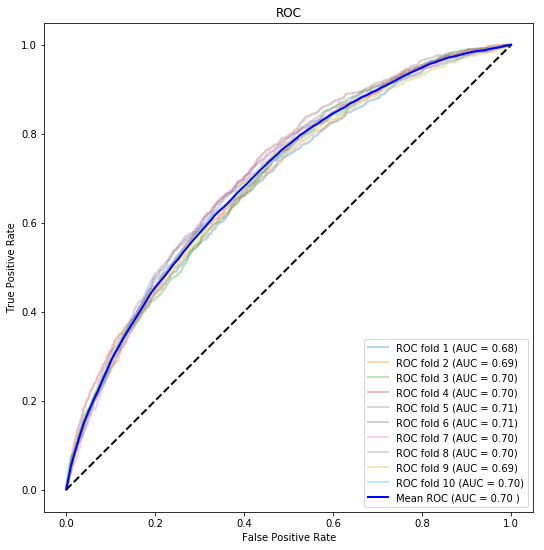

In [149]:
#Plot ROC curve for LDA
ROC_LDA = draw_ROC(LinearDiscriminantAnalysis(), X_reduced, y_reduced)

**5-Nearest Neighbour ROC Curve**

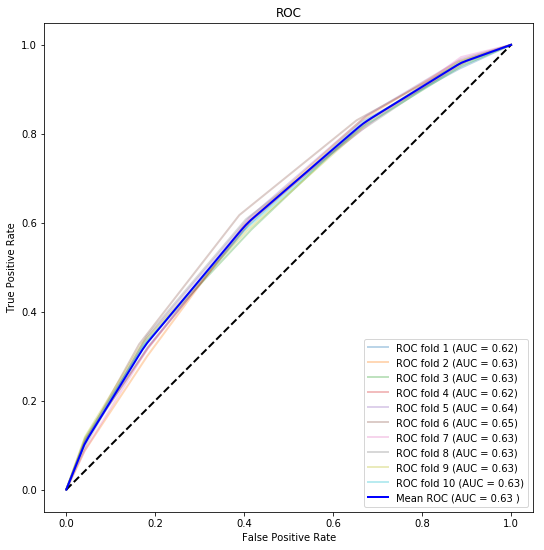

In [150]:
#Plot ROC curve for 5-NN
ROC_knn = draw_ROC(KNeighborsClassifier(n_neighbors = neigh), X_reduced, y_reduced)

## 5. Lasso-Reduced Model

The answer for this question is entirely in the PDF submitted.

## 6. Lasso Approach

We first define a function `lasso_classifier` to simplify the running of the model, and to create a confusion matrix.

In [156]:
def lasso_classifier(classifier_type, X, y):
    kfold = KFold(n_splits = k, random_state = 42)
    kfold.get_n_splits(X)

    score_list = []
    best_score = 0

    conf_matrix = np.zeros((2,2))

    for train_index, valid_index in kfold.split(X):
        #Split training / validation set at Kth fold
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        #Undersample training data
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X_train, y_train)
        
        #Scale undersampled training set and validation set, using scale fit from training data
        scaler = StandardScaler().fit(X_res)
        X_train_scaled = scaler.transform(X_res)
        X_valid_scaled = scaler.transform(X_valid)
    
        #Create classifier object
        clf = classifier_type
        clf.fit(X_train_scaled, y_res)
        score = clf.score(X_valid_scaled, y_valid)
        score_list.append(score)
        
        y_pred_lasso = clf.predict(X_valid_scaled)
        
        y_pred_lasso_2 = []
        for i in range(len(y_pred_lasso)):
            if y_pred_lasso[i] >= 0.5:
                y_pred_lasso_2.append(1)
            else:
                y_pred_lasso_2.append(0) 
        
        #Create confusion matrix for fold k
        conf = confusion_matrix(y_valid, y_pred_lasso_2)
    
        #Iteratively add confusion matrix to the previous
        conf_matrix[0][0] += conf[0][0]
        conf_matrix[0][1] += conf[0][1]
        conf_matrix[1][0] += conf[1][0]
        conf_matrix[1][1] += conf[1][1]


    conf_clf = conf_matrix.transpose()
    conf_clf = normalize(conf_clf, axis = 0, norm = 'l1')
    conf_clf = pd.DataFrame(conf_clf, index = ['Pred \'Current\'', 'Pred \'Fail\''],
                                columns = ['Act \'Current\'', 'Act \'Fail\''])
    
    avg_accuracy = sum(score_list) / len(score_list)
    avg_accuracy
    
    return conf_clf, avg_accuracy

Next, we call the function above with the desired paramater of $\alpha = 0.1$

In [157]:
#Run lasso model and return confusion matrix
conf_lasso, score_lasso = lasso_classifier(Lasso(alpha = 0.1), X, y)
print(conf_lasso)

                Act 'Current'  Act 'Fail'
Pred 'Current'       0.684823    0.412477
Pred 'Fail'          0.315177    0.587523


## 7. Running the LASSO-MODEL

We set an arbritrary list of lambdas and iterate through them to see which lambda returns a model with 10 columns.

In [170]:
#Find the value for alpha which yields 10 coefs
lam = [0.010, 0.012, 0.016, 0.0168, 0.017, 0.018, 0.05, 0.1, 0.5, 1]

rus_lasso = RandomUnderSampler(random_state = 42)
X_res_lasso, y_res_lasso = rus_lasso.fit_resample(X, y)

scaler = StandardScaler().fit(X_res_lasso)
X_train_lasso = scaler.transform(X_res_lasso)

for i in lam:
    lasso = Lasso(alpha = i)
    lasso.fit(X_train_lasso, y_res_lasso)
    
    coeffs = lasso.coef_
    
    b = 0
    for j in range(len(coeffs)):
        if coeffs[j] != 0:
            b += 1
            
    print('A lambda of ' + str(i) + ' leaves the model with ' + str(b) + ' variables')
    if b == 10:
        lamb = i

A lambda of 0.01 leaves the model with 16 variables
A lambda of 0.012 leaves the model with 15 variables
A lambda of 0.016 leaves the model with 12 variables
A lambda of 0.0168 leaves the model with 10 variables
A lambda of 0.017 leaves the model with 9 variables
A lambda of 0.018 leaves the model with 8 variables
A lambda of 0.05 leaves the model with 1 variables
A lambda of 0.1 leaves the model with 1 variables
A lambda of 0.5 leaves the model with 0 variables
A lambda of 1 leaves the model with 0 variables


Based on the results above, we can see that the model is left with 10 variables when $lambda = 0.0168$

Next, we run the LASSO function using this lambda value and allow it to determine which 10 variables are the important attributes for our Lasso-Model.

In [171]:
#Based on redults above, we have 10 variables when lambda = 0.0168
lasso_model = Lasso(alpha = lamb)

lasso_model.fit(X_train_lasso, y_res_lasso)

lasso_model_coef = list(lasso_model.coef_)

all_features = list(df_s[df_s.columns[1:]])
select_features = []

for i in range(len(lasso_model_coef)):
    if lasso_model_coef[i] != 0:
        select_features.append(all_features[i])
        
lasso_model_features = pd.DataFrame(select_features, columns = ['Features'])
lasso_model_features

,Features
0,sub_grade
1,installment
2,pymnt_plan
3,fico_range_high
4,inq_last_12m
5,inq_last_6mths
6,open_rv_24m
7,tot_hi_cred_lim
8,home_ownership_1
9,purpose_1


## 8. Final Model Selection

Based on our detailed explanation (found in the PDF submitted), we select 10 attributes for a final model. Below we chose to run an LDA model using this reduced dataset.

In [183]:
#Define the final set of features and run LDA model using this final reduced dataset
final_features = ['sub_grade', 'installment', 'fico_range_high', 'inq_last_6mths', 'open_rv_24m',\
                  'total_bc_limit', 'home_ownership_1', 'annual_inc', 'emp_length', 'total_bal_ex_mort']

X_reduced_final = np.array(df_s[final_features])

conf_final, score_final = classifier(LinearDiscriminantAnalysis(), X_reduced_final, y)
print('The accuracy of the final model is %s%%\n' %round((score_final*100),2))

The accuracy of the final model is 66.45%



In [184]:
#Return confustion matrix for the final model
print(conf_final)

                Act 'Current'  Act 'Fail'
Pred 'Current'       0.672684    0.378854
Pred 'Fail'          0.327316    0.621146


## 9. Full Model vs. Final Model

The answer for this question is entirely in the PDF submitted.

## 10. Model Enhancement

The answer for this question is entirely in the PDF submitted.

# Part 2 

## 11. Evaluating Model on Test Data

In order to run the model, we must do similar data wrangling as was done in Part 1. We load the data, convert the dependant variable to be binary, convert all categorical variables to binary, and finally split the independant variables and dependant variable.

In [214]:
# #Load data for Part 2
df2 = pd.read_csv('Loan_data_part_II.csv')

#Make loan_status binary: current = 0, fail = 1
df2['loan_status'] = df2['loan_status'].replace(['Current', 'Fail'], [0, 1])
df2 = df2.drop(['id'], axis = 1)

#Convert categorical columns to binary
df2 = pd.get_dummies(df2, columns = ['home_ownership', 'purpose', 'verification_status'])

#Split independant and dependant variables into x_test and y_test
X_test = np.array(df2[df2.columns[1:]])
y_test = np.array(df2['loan_status'])

In order to run the FINAL-MODEL on the test data, we must create a reduced test dataset as well using the final features explained in Question 8.

In [218]:
#Reduce test set based on final selected features
X_test_red = np.array(df2[final_features])

Similar to Question 4, to make the ROC Curve plotting process easier, we define a function `draw_test_ROC`. Below, we use this function to plot the curves.

In [222]:
#Define function to draw ROC curve for the test dataset

# ROC FUNCTION BELOW IS BORROWS HEAVILY FROM FOLLOWING KERNEL:
# Title: ROC Curve with k-Fold CV
# Author: DATAI Group
# Date: NA
# Code version: NA
# Availability: https://www.kaggle.com/kanncaa1/roc-curve-with-k-fold-cv

def draw_test_ROC(classifier_type, X_train, y_train, X_test, y_test):
    fig1 = plt.figure(figsize = [9, 9])
    ax1 = fig1.add_subplot(111, aspect = 'equal')

    #Undersample training data
    rus = RandomUnderSampler(random_state = 42)
    X_res, y_res = rus.fit_resample(X_train, y_train)

    ##Scale undersampled training set and validation set, using scale fit from training data
    scaler = StandardScaler().fit(X_res)
    X_train_scaled = scaler.transform(X_res)
    X_test_scaled = scaler.transform(X_test)

    clf = classifier_type.fit(X_train_scaled, y_res)
        
    prediction = clf.predict_proba(X_test_scaled)
    fpr, tpr, t = roc_curve(y_test, prediction[:, 1])
    roc_auc = auc(fpr, tpr)   
    plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black')
    plt.plot(fpr, tpr, color = 'blue',\
             label=r'ROC (AUC = %0.2f )' % (roc_auc), lw=  2, alpha = 1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc = "lower right")
    plt.show()

**Logistic Regression Model**

The following is the ROC curve for the out-of-sample test data for the Logistic Regression model using the FINAL-MODEL from Question 8.

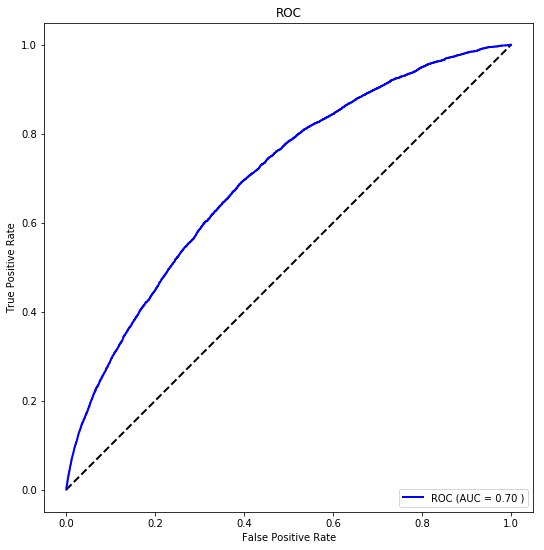

In [224]:
#Plot the ROC curve using the Logit model and final_reduced columns
draw_test_ROC(LogisticRegression(solver = 'lbfgs'), X_reduced_final, y_reduced, X_test_red, y_test)

**LDA Model**

The following is the ROC curve for the out-of-sample test data for the LDA model using the FINAL-MODEL from Question 8.

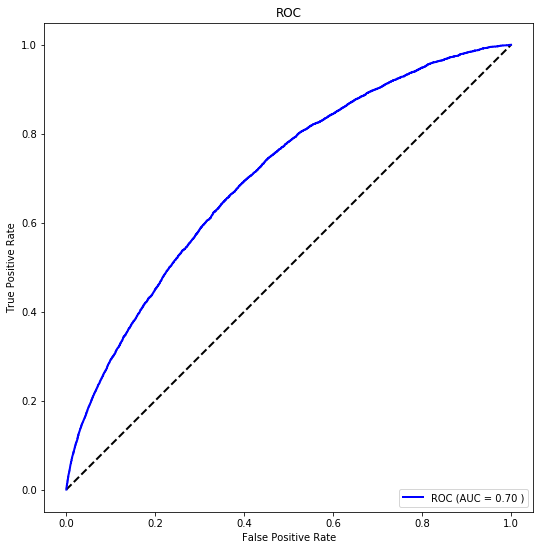

In [225]:
#Plot the ROC curve using the LDA model and final_reduced columns
draw_test_ROC(LinearDiscriminantAnalysis(), X_reduced_final, y_reduced, X_test_red, y_test)

**5-Nearest Neighbour Model**

The following is the ROC curve for the out-of-sample test data for the 5-NN model using the FINAL-MODEL from Question 8.

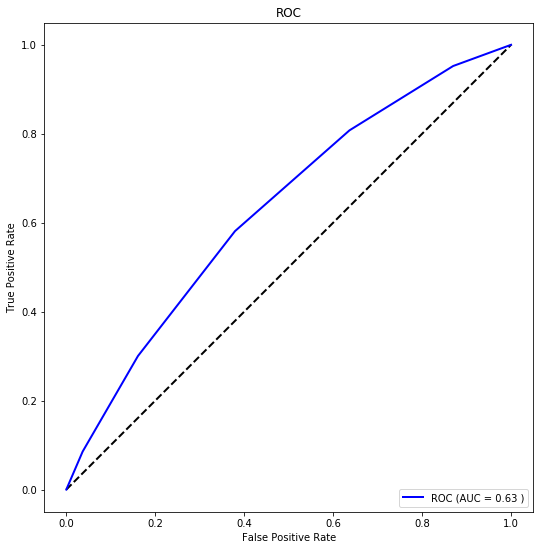

In [227]:
#Plot the ROC curve using the 5-NN model and final_reduced columns
draw_test_ROC(KNeighborsClassifier(n_neighbors = neigh), X_reduced_final, y_reduced, X_test_red, y_test)

### REFERENCES

 1. James, G., Witten, D., Hastie, T. and Tibshirani, R. (2013). An Introduction to Statistical Learning. New York, NY: Springer New York.
 2. DATAI Group, Smith, J (No Data) ROC Curve with k-Fold CV (No version) [Source code]. https://www.kaggle.com/kanncaa1/roc-curve-with-k-fold-cv <br>
 3. Altini, M. (2015). Dealing with imbalanced data: undersampling, oversampling and proper cross-validation. [online] Marco Altini. Available at: https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation [Accessed 12 Feb. 2019]. <br>